# 8 Pilares Estadisticos: Evaluacion de Balanza de Pagos

**Traduciendo conceptos academicos para Data Science al mundo real**

Este notebook evalua los datos de Balanza de Pagos procesados por `ETL_Principales.py`, aplicando los 8 pilares estadisticos:

1. **Distribuciones** - Forma de los datos
2. **Centro de Gravedad** - Media, Mediana, Moda
3. **Fiabilidad** - Riesgo y volatilidad
4. **Margen de Error** - Intervalos de confianza
5. **Pruebas de Hipotesis** - Chi-cuadrada
6. **Regresion/Prediccion** - Machine Learning
7. **Series de Tiempo** - Tendencias y estacionalidad
8. **ANOVA** - Comparacion entre grupos

**Variables principales:**
- Cuenta Corriente
- Exportaciones e Importaciones
- Balanza de Bienes y Servicios
- Remesas
- Ingresos por Turismo

In [1]:
# Importaciones
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from scipy.stats import chi2_contingency, shapiro, normaltest, kruskal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

BASE_DIR = Path('..').resolve()
DATOS_RESULTADO = BASE_DIR / 'Datos_Resultado'
print(f"Directorio base: {BASE_DIR}")

Directorio base: C:\Users\ARTUROJF\Desktop\Final


## Carga de Datos

In [2]:
# Cargar datos
path_datos = DATOS_RESULTADO / 'BalanzaPagos_Trimestral.csv'
df = pd.read_csv(path_datos) if path_datos.exists() else pd.DataFrame()

print(f"Datos: {len(df)} filas x {len(df.columns)} columnas")
print(f"\nColumnas: {df.columns.tolist()}")
df.head()

Datos: 94 filas x 10 columnas

Columnas: ['periodo', 'CuentaCorriente', 'Exportaciones', 'IngresosTurismo', 'Remesas', 'Importaciones', 'BalanzaBienes', 'BalanzaServicios', 'BalanzaIngresoPrimario', 'BalanzaIngresoSecundario']


,periodo,CuentaCorriente,Exportaciones,IngresosTurismo,Remesas,Importaciones,BalanzaBienes,BalanzaServicios,BalanzaIngresoPrimario,BalanzaIngresoSecundario
0,2002-01-01,-3627.093766,36677.187,2413.586,2174.435000,38121.517,-1431.944326,-520.406919,-3983.807510,2309.064989
1,2002-04-01,-2032.123022,41480.504,2144.941,2578.080000,42977.609,-1492.583948,-1439.292142,-1807.734396,2707.487464
2,2002-07-01,-2711.575496,41367.209,2017.510,2552.811100,42925.083,-1571.399636,-1182.674365,-2637.059303,2679.557808
3,2002-10-01,-4027.253254,41521.080,2281.948,2509.122000,44654.680,-3139.032399,-1416.955874,-2112.152543,2640.887562
4,2003-01-01,-1700.305073,39051.494,2547.862,3170.126737,39189.409,-137.159866,-709.201785,-4158.363918,3304.420496


In [3]:
# Preparar datos
df['periodo'] = pd.to_datetime(df['periodo'])
df = df.sort_values('periodo').reset_index(drop=True)
df['TRIMESTRE'] = df['periodo'].dt.quarter
df['year'] = df['periodo'].dt.year

# Variables numericas
cols_numericas = ['CuentaCorriente', 'Exportaciones', 'Importaciones', 'Remesas', 
                  'IngresosTurismo', 'BalanzaBienes', 'BalanzaServicios', 
                  'BalanzaIngresoPrimario', 'BalanzaIngresoSecundario']
cols_numericas = [c for c in cols_numericas if c in df.columns]

VAR_PRINCIPAL = 'CuentaCorriente'
print(f"Variable principal: {VAR_PRINCIPAL}")
print(f"Rango: {df[VAR_PRINCIPAL].min():,.0f} a {df[VAR_PRINCIPAL].max():,.0f} millones USD")
print(f"\nEstadisticas:")
df[cols_numericas].describe()

Variable principal: CuentaCorriente
Rango: -24,580 a 17,331 millones USD

Estadisticas:


,CuentaCorriente,Exportaciones,Importaciones,Remesas,IngresosTurismo,BalanzaBienes,BalanzaServicios,BalanzaIngresoPrimario,BalanzaIngresoSecundario
count,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000
mean,-3143.470452,92074.238277,93751.990670,7959.744948,4303.001499,-1684.795204,-2682.625796,-6778.810983,8002.761530
std,5886.194145,34177.105250,34589.625057,3871.693932,1974.459380,3891.543280,1275.477807,5482.028337,3813.990335
min,-24580.075234,36677.187000,38121.517000,2174.435000,522.019874,-13185.804958,-5940.132922,-32533.604739,2309.064989
25%,-5754.621010,63873.068250,66558.269500,5678.534705,2880.437707,-3040.684449,-3615.777800,-7648.817440,5743.247638
50%,-2536.548129,92491.093000,92775.426500,6470.496807,3614.020187,-1719.734427,-2591.569919,-5834.566017,6527.541915
75%,-327.119597,113399.155000,113037.620750,9581.000813,5461.707126,-381.998980,-1702.660046,-3448.577881,9605.241945
max,17330.743363,163826.326000,164639.207000,17243.847473,10268.501810,16208.584131,1246.571495,-165.163883,17098.149238


---
## PILAR 1: Distribuciones

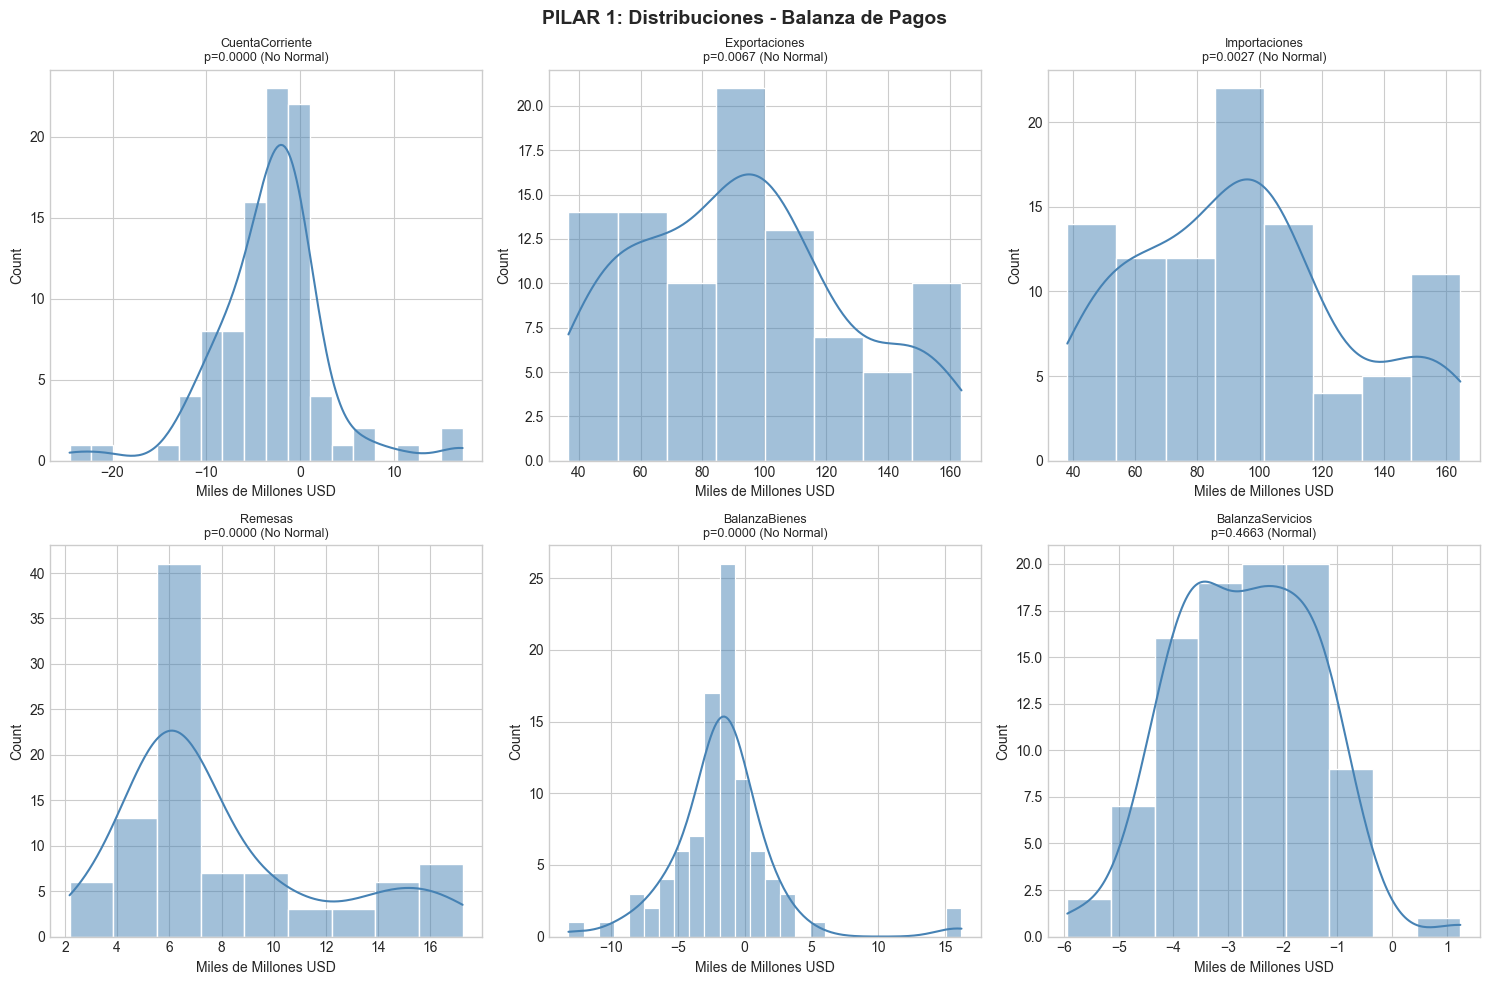


RESUMEN DE NORMALIDAD:
CuentaCorriente                | p=0.0000 | No Normal
Exportaciones                  | p=0.0067 | No Normal
Importaciones                  | p=0.0027 | No Normal
Remesas                        | p=0.0000 | No Normal
IngresosTurismo                | p=0.0000 | No Normal
BalanzaBienes                  | p=0.0000 | No Normal
BalanzaServicios               | p=0.4663 | Normal
BalanzaIngresoPrimario         | p=0.0000 | No Normal
BalanzaIngresoSecundario       | p=0.0000 | No Normal


In [4]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('PILAR 1: Distribuciones - Balanza de Pagos', fontsize=14, fontweight='bold')

vars_plot = ['CuentaCorriente', 'Exportaciones', 'Importaciones', 'Remesas', 'BalanzaBienes', 'BalanzaServicios']
vars_plot = [v for v in vars_plot if v in df.columns]

for idx, var in enumerate(vars_plot[:6]):
    ax = axes[idx // 3, idx % 3]
    data = df[var].dropna()
    sns.histplot(data/1000, kde=True, ax=ax, color='steelblue', edgecolor='white')
    
    if len(data) >= 20:
        stat, p = shapiro(data) if len(data) < 5000 else normaltest(data)
        ax.set_title(f'{var}\np={p:.4f} ({"Normal" if p > 0.05 else "No Normal"})', fontsize=9)
    ax.set_xlabel('Miles de Millones USD')

plt.tight_layout()
plt.show()

print("\nRESUMEN DE NORMALIDAD:")
print("="*60)
for var in cols_numericas:
    data = df[var].dropna()
    if len(data) >= 20:
        _, p = shapiro(data) if len(data) < 5000 else normaltest(data)
        print(f"{var:30} | p={p:.4f} | {'Normal' if p > 0.05 else 'No Normal'}")

---
## PILAR 2: Centro de Gravedad

In [5]:
print("PILAR 2: MEDIDAS DE TENDENCIA CENTRAL")
print("="*80)

stats_centro = []
for var in cols_numericas:
    data = df[var].dropna()
    if len(data) > 0:
        stats_centro.append({
            'Variable': var,
            'Media': data.mean(),
            'Mediana': data.median(),
            'Desv. Std': data.std(),
            'Dif (%)': ((data.mean() - data.median()) / abs(data.median()) * 100) if data.median() != 0 else 0
        })

df_centro = pd.DataFrame(stats_centro)
print(df_centro.to_string(index=False))

PILAR 2: MEDIDAS DE TENDENCIA CENTRAL
                Variable        Media      Mediana    Desv. Std    Dif (%)
         CuentaCorriente -3143.470452 -2536.548129  5886.194145 -23.927097
           Exportaciones 92074.238277 92491.093000 34177.105250  -0.450697
           Importaciones 93751.990670 92775.426500 34589.625057   1.052611
                 Remesas  7959.744948  6470.496807  3871.693932  23.015978
         IngresosTurismo  4303.001499  3614.020187  1974.459380  19.064125
           BalanzaBienes -1684.795204 -1719.734427  3891.543280   2.031664
        BalanzaServicios -2682.625796 -2591.569919  1275.477807  -3.513541
  BalanzaIngresoPrimario -6778.810983 -5834.566017  5482.028337 -16.183637
BalanzaIngresoSecundario  8002.761530  6527.541915  3813.990335  22.599926


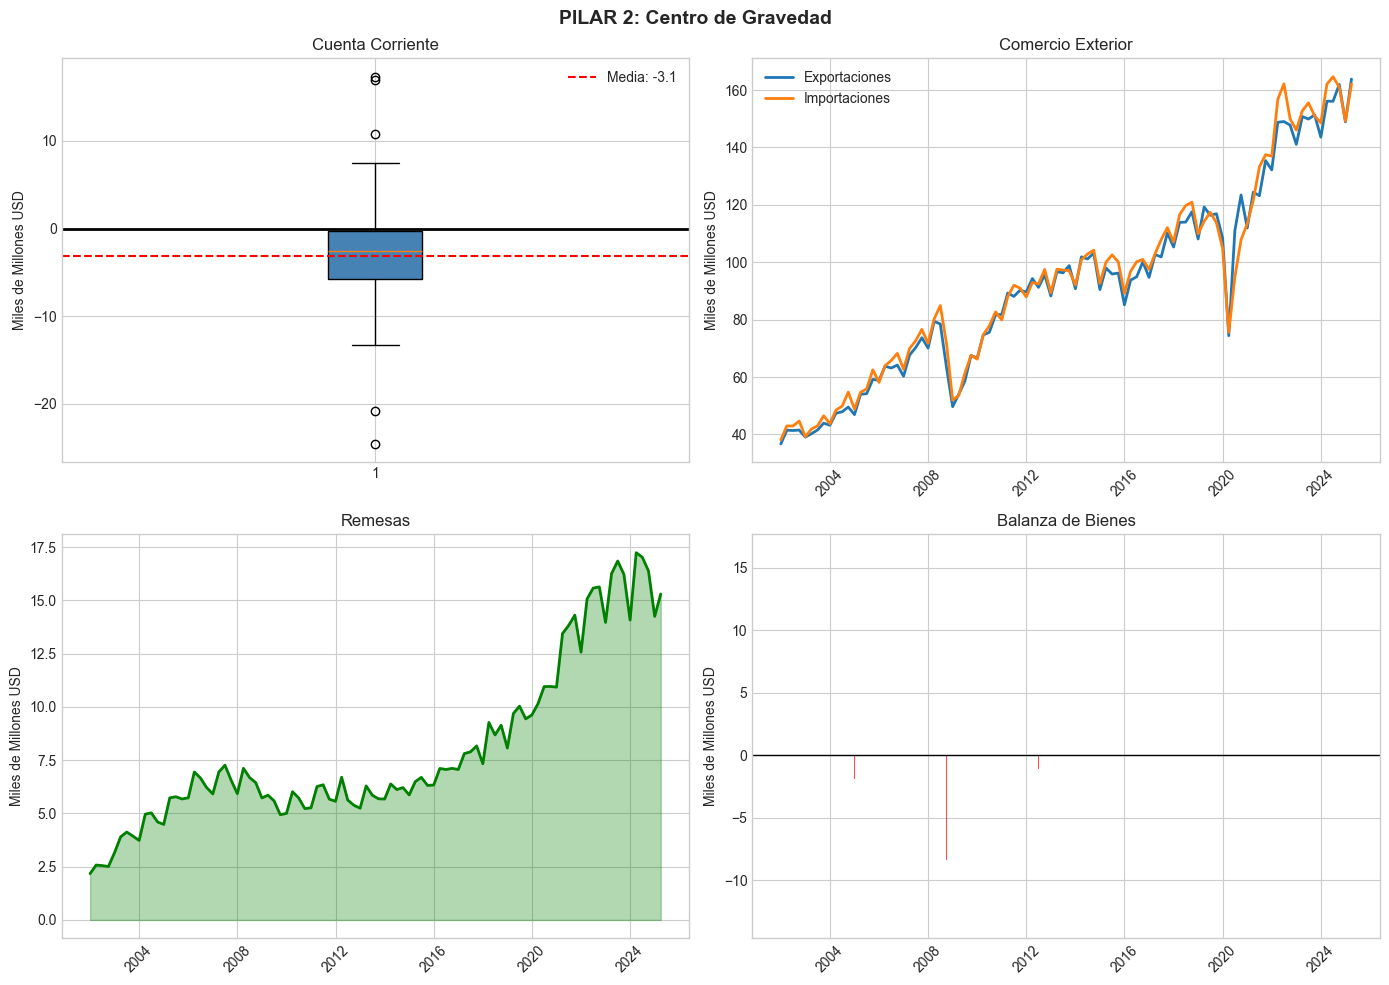

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('PILAR 2: Centro de Gravedad', fontsize=14, fontweight='bold')

# Cuenta Corriente
data = df['CuentaCorriente'].dropna()
bp = axes[0, 0].boxplot(data/1000, patch_artist=True)
bp['boxes'][0].set_facecolor('steelblue')
axes[0, 0].axhline(0, color='black', linewidth=2)
axes[0, 0].axhline(data.mean()/1000, color='red', linestyle='--', label=f'Media: {data.mean()/1000:.1f}')
axes[0, 0].set_ylabel('Miles de Millones USD')
axes[0, 0].set_title('Cuenta Corriente')
axes[0, 0].legend()

# Exportaciones vs Importaciones
axes[0, 1].plot(df['periodo'], df['Exportaciones']/1000, label='Exportaciones', linewidth=2)
axes[0, 1].plot(df['periodo'], df['Importaciones']/1000, label='Importaciones', linewidth=2)
axes[0, 1].set_ylabel('Miles de Millones USD')
axes[0, 1].set_title('Comercio Exterior')
axes[0, 1].legend()
axes[0, 1].tick_params(axis='x', rotation=45)

# Remesas
if 'Remesas' in df.columns:
    axes[1, 0].plot(df['periodo'], df['Remesas']/1000, color='green', linewidth=2)
    axes[1, 0].fill_between(df['periodo'], df['Remesas']/1000, alpha=0.3, color='green')
    axes[1, 0].set_ylabel('Miles de Millones USD')
    axes[1, 0].set_title('Remesas')
    axes[1, 0].tick_params(axis='x', rotation=45)

# Balanza Comercial
if 'BalanzaBienes' in df.columns:
    bb = df['BalanzaBienes']
    colors = ['green' if x > 0 else 'red' for x in bb]
    axes[1, 1].bar(df['periodo'], bb/1000, color=colors, alpha=0.7)
    axes[1, 1].axhline(0, color='black', linewidth=1)
    axes[1, 1].set_ylabel('Miles de Millones USD')
    axes[1, 1].set_title('Balanza de Bienes')
    axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

---
## PILAR 3: Fiabilidad

In [7]:
print("PILAR 3: FIABILIDAD Y VOLATILIDAD")
print("="*80)

stats_fiab = []
for var in cols_numericas:
    data = df[var].dropna()
    if len(data) > 0:
        cv = (data.std() / abs(data.mean()) * 100) if data.mean() != 0 else np.nan
        Q1, Q3 = data.quantile([0.25, 0.75])
        IQR = Q3 - Q1
        outliers = ((data < Q1 - 1.5*IQR) | (data > Q3 + 1.5*IQR)).sum()
        cambio = data.pct_change().dropna() * 100
        
        stats_fiab.append({
            'Variable': var,
            'CV (%)': cv,
            'Cambio Prom (%)': cambio.mean(),
            'Volatilidad (%)': cambio.std(),
            'Outliers': outliers
        })

df_fiab = pd.DataFrame(stats_fiab)
print(df_fiab.to_string(index=False))

PILAR 3: FIABILIDAD Y VOLATILIDAD
                Variable     CV (%)  Cambio Prom (%)  Volatilidad (%)  Outliers
         CuentaCorriente 187.251455      -324.758469      2717.439606         5
           Exportaciones  37.119075         2.049094         9.402254         0
           Importaciones  36.894817         1.936179         8.440074         0
                 Remesas  48.640930         2.695262        11.178469         8
         IngresosTurismo  45.885631         5.450305        29.328475         2
           BalanzaBienes 230.980197         0.861449       613.084128         8
        BalanzaServicios  47.545871        16.572394       101.163132         1
  BalanzaIngresoPrimario  80.870057        67.807877       372.877920         9
BalanzaIngresoSecundario  47.658428         2.621752        11.152859         8


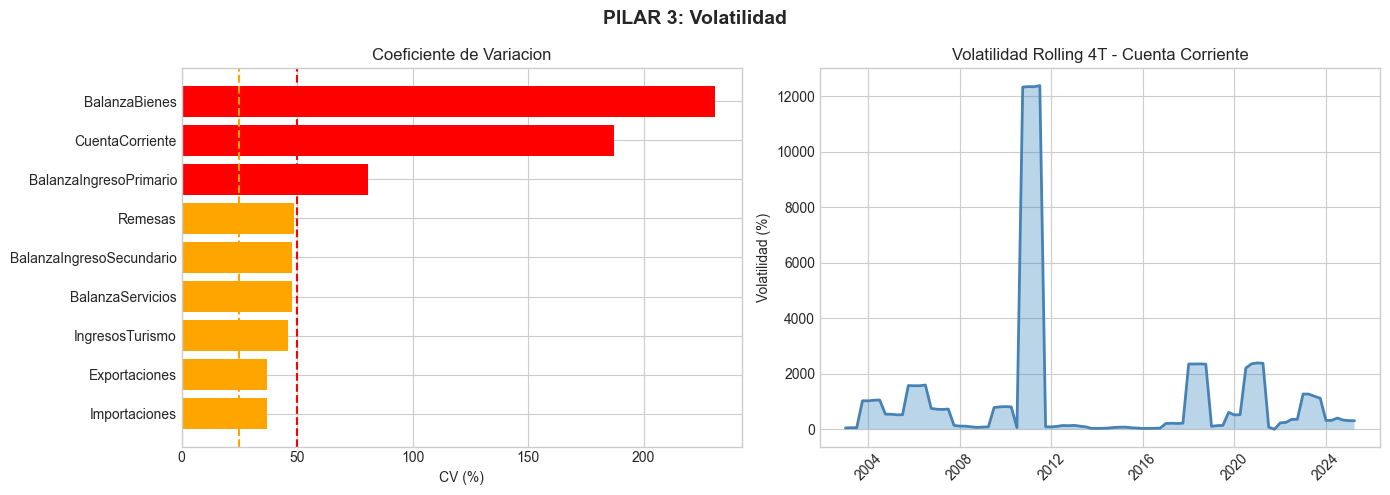

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('PILAR 3: Volatilidad', fontsize=14, fontweight='bold')

# CV por variable
df_fiab_sorted = df_fiab.sort_values('CV (%)', ascending=True)
colors = ['red' if cv > 50 else 'orange' if cv > 25 else 'green' for cv in df_fiab_sorted['CV (%)']]
axes[0].barh(df_fiab_sorted['Variable'], df_fiab_sorted['CV (%)'], color=colors)
axes[0].axvline(25, color='orange', linestyle='--')
axes[0].axvline(50, color='red', linestyle='--')
axes[0].set_xlabel('CV (%)')
axes[0].set_title('Coeficiente de Variacion')

# Rolling volatilidad Cuenta Corriente
vol_cc = df['CuentaCorriente'].pct_change().rolling(4).std() * 100
axes[1].plot(df['periodo'], vol_cc, color='steelblue', linewidth=2)
axes[1].fill_between(df['periodo'], vol_cc, alpha=0.3)
axes[1].set_ylabel('Volatilidad (%)')
axes[1].set_title('Volatilidad Rolling 4T - Cuenta Corriente')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

---
## PILAR 4: Margen de Error

In [9]:
print("PILAR 4: INTERVALOS DE CONFIANZA (95%)")
print("="*80)

def intervalo_confianza(data, confianza=0.95):
    n = len(data)
    media = data.mean()
    sem = stats.sem(data)
    h = sem * stats.t.ppf((1 + confianza) / 2, n - 1)
    return media - h, media + h, h

ic_results = []
for var in cols_numericas:
    data = df[var].dropna()
    if len(data) >= 10:
        ic_low, ic_high, margen = intervalo_confianza(data)
        ic_results.append({
            'Variable': var,
            'Media': data.mean(),
            'IC Inferior': ic_low,
            'IC Superior': ic_high,
            'Margen (%)': abs(margen / data.mean() * 100) if data.mean() != 0 else 0
        })

df_ic = pd.DataFrame(ic_results)
print(df_ic.to_string(index=False))

PILAR 4: INTERVALOS DE CONFIANZA (95%)
                Variable        Media  IC Inferior   IC Superior  Margen (%)
         CuentaCorriente -3143.470452 -4349.079667  -1937.861237   38.352809
           Exportaciones 92074.238277 85074.089792  99074.386761    7.602722
           Importaciones 93751.990670 86667.349954 100836.631387    7.556790
                 Remesas  7959.744948  7166.745300   8752.744595    9.962626
         IngresosTurismo  4303.001499  3898.593088   4707.409911    9.398287
           BalanzaBienes -1684.795204 -2481.860391   -887.730017   47.309322
        BalanzaServicios -2682.625796 -2943.868928  -2421.382663    9.738337
  BalanzaIngresoPrimario -6778.810983 -7901.639030  -5655.982935   16.563790
BalanzaIngresoSecundario  8002.761530  7221.580723   8783.942337    9.761391


---
## PILAR 5: Pruebas de Hipotesis

In [10]:
print("PILAR 5: PRUEBAS DE HIPOTESIS")
print("="*80)

# Hipotesis 1: Cuenta corriente vs Trimestre
print("\n--- H1: Cuenta Corriente vs Trimestre ---")
df_test = df.copy()
df_test['cc_signo'] = df_test['CuentaCorriente'].apply(lambda x: 'Superavit' if x > 0 else 'Deficit')

contingencia = pd.crosstab(df_test['cc_signo'], df_test['TRIMESTRE'])
print(contingencia)

if contingencia.shape[0] > 1 and contingencia.shape[1] > 1:
    chi2, p_value, dof, expected = chi2_contingency(contingencia)
    print(f"\nChi2={chi2:.4f}, p={p_value:.4f}")
    print(f"Conclusion: {'RECHAZAR H0' if p_value < 0.05 else 'NO RECHAZAR H0'}")
else:
    p_value = 1.0

PILAR 5: PRUEBAS DE HIPOTESIS

--- H1: Cuenta Corriente vs Trimestre ---
TRIMESTRE   1   2   3   4
cc_signo                 
Deficit    23  18  20  17
Superavit   1   6   3   6

Chi2=5.4856, p=0.1395
Conclusion: NO RECHAZAR H0


In [11]:
# Hipotesis 2: Cambio estructural 2010
print("\n--- H2: Cuenta Corriente Pre/Post 2010 ---")
df_test['era'] = df_test['periodo'].apply(lambda x: 'Pre-2010' if x.year < 2010 else 'Post-2010')

contingencia2 = pd.crosstab(df_test['cc_signo'], df_test['era'])
print(contingencia2)

if contingencia2.shape[0] > 1 and contingencia2.shape[1] > 1:
    chi2_2, p_value_2, _, _ = chi2_contingency(contingencia2)
    print(f"\nChi2={chi2_2:.4f}, p={p_value_2:.4f}")
else:
    p_value_2 = 1.0


--- H2: Cuenta Corriente Pre/Post 2010 ---
era        Post-2010  Pre-2010
cc_signo                      
Deficit           48        30
Superavit         14         2

Chi2=2.9129, p=0.0879


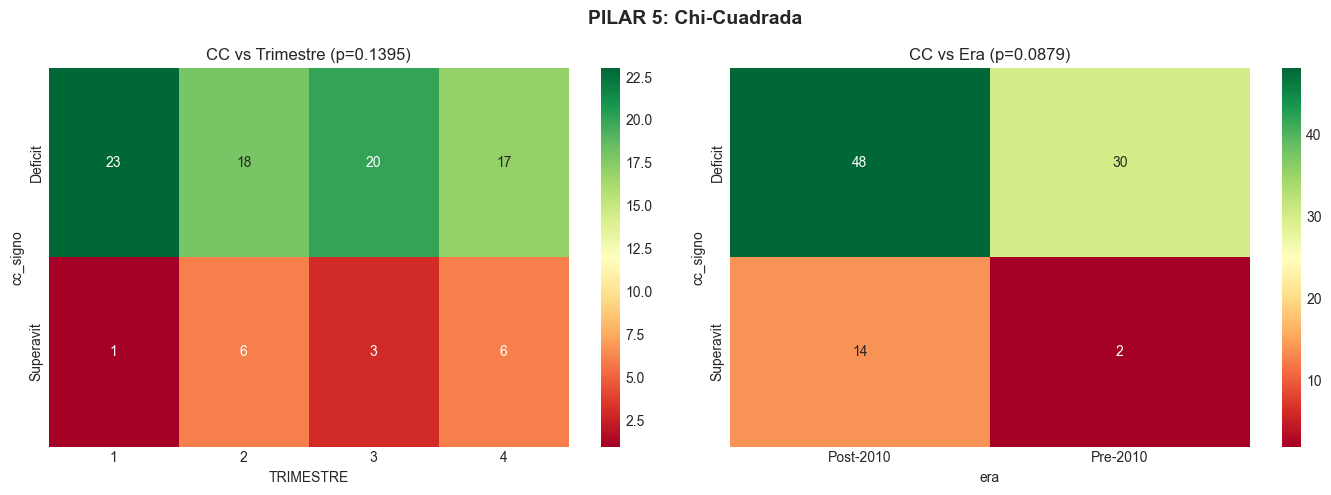

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('PILAR 5: Chi-Cuadrada', fontsize=14, fontweight='bold')

sns.heatmap(contingencia, annot=True, fmt='d', cmap='RdYlGn', ax=axes[0])
axes[0].set_title(f'CC vs Trimestre (p={p_value:.4f})')

sns.heatmap(contingencia2, annot=True, fmt='d', cmap='RdYlGn', ax=axes[1])
axes[1].set_title(f'CC vs Era (p={p_value_2:.4f})')

plt.tight_layout()
plt.show()

---
## PILAR 6: Prediccion ML

In [13]:
print("PILAR 6: MACHINE LEARNING")
print("="*80)

# Predecir Cuenta Corriente usando comercio exterior
features = ['Exportaciones', 'Importaciones', 'Remesas', 'TRIMESTRE', 'year']
features = [f for f in features if f in df.columns]
target = 'CuentaCorriente'

df_ml = df[features + [target]].dropna()
X = df_ml[features]
y = df_ml[target]

print(f"Features: {features}")
print(f"Observaciones: {len(df_ml)}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

PILAR 6: MACHINE LEARNING
Features: ['Exportaciones', 'Importaciones', 'Remesas', 'TRIMESTRE', 'year']
Observaciones: 94


In [14]:
modelos = {
    'Regresion Lineal': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

resultados = []
predicciones = {}

for nombre, modelo in modelos.items():
    if 'Forest' in nombre or 'Boosting' in nombre:
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)
    else:
        modelo.fit(X_train_scaled, y_train)
        y_pred = modelo.predict(X_test_scaled)
    
    resultados.append({
        'Modelo': nombre,
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred)
    })
    predicciones[nombre] = y_pred

df_resultados = pd.DataFrame(resultados).sort_values('R2', ascending=False)
print(df_resultados.to_string(index=False))
mejor_modelo = df_resultados.iloc[0]['Modelo']
print(f"\n*** MEJOR: {mejor_modelo} (R2={df_resultados.iloc[0]['R2']:.4f}) ***")

           Modelo        RMSE         MAE       R2
Gradient Boosting 1948.064685 1541.014360 0.443226
            Ridge 2009.506383 1665.371836 0.407551
    Random Forest 2077.181320 1774.328359 0.366975
 Regresion Lineal 2366.417691 2016.445473 0.178410

*** MEJOR: Gradient Boosting (R2=0.4432) ***


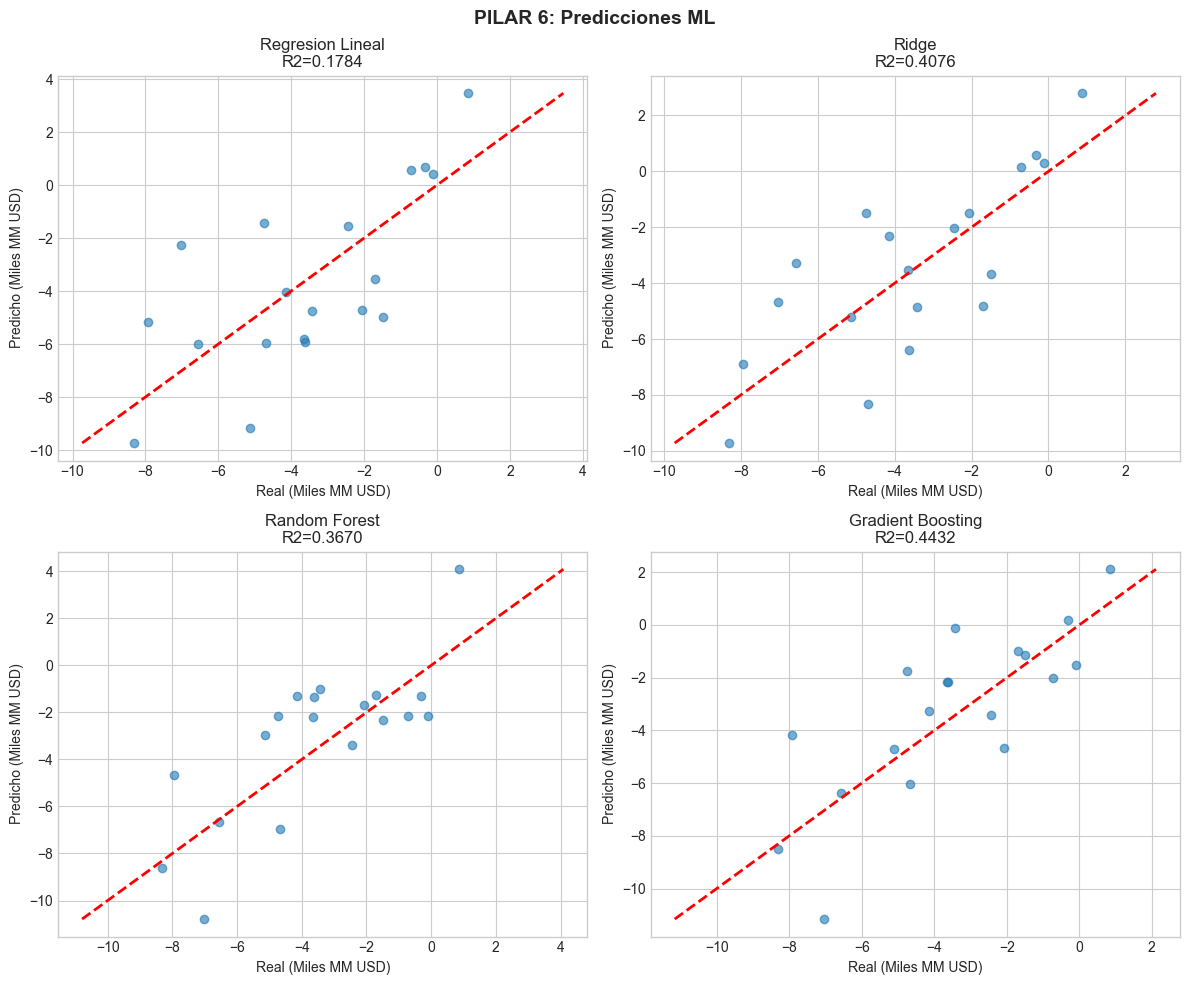

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('PILAR 6: Predicciones ML', fontsize=14, fontweight='bold')

for idx, (nombre, y_pred) in enumerate(predicciones.items()):
    ax = axes[idx // 2, idx % 2]
    ax.scatter(y_test/1000, y_pred/1000, alpha=0.6)
    lims = [min(y_test.min(), y_pred.min())/1000, max(y_test.max(), y_pred.max())/1000]
    ax.plot(lims, lims, 'r--', linewidth=2)
    ax.set_xlabel('Real (Miles MM USD)')
    ax.set_ylabel('Predicho (Miles MM USD)')
    ax.set_title(f'{nombre}\nR2={r2_score(y_test, y_pred):.4f}')

plt.tight_layout()
plt.show()

---
## PILAR 7: Series de Tiempo

In [16]:
print("PILAR 7: SERIES DE TIEMPO")
print("="*80)

ts_data = df.set_index('periodo')['CuentaCorriente'].dropna().asfreq('QS')
print(f"Serie: {ts_data.index.min()} a {ts_data.index.max()}")
print(f"Observaciones: {len(ts_data)}")

adf_result = adfuller(ts_data.dropna())
print(f"\nTest ADF: stat={adf_result[0]:.4f}, p={adf_result[1]:.4f}")
print(f"Conclusion: {'ESTACIONARIA' if adf_result[1] < 0.05 else 'NO ESTACIONARIA'}")

PILAR 7: SERIES DE TIEMPO
Serie: 2002-01-01 00:00:00 a 2025-04-01 00:00:00
Observaciones: 94

Test ADF: stat=-2.0745, p=0.2549
Conclusion: NO ESTACIONARIA


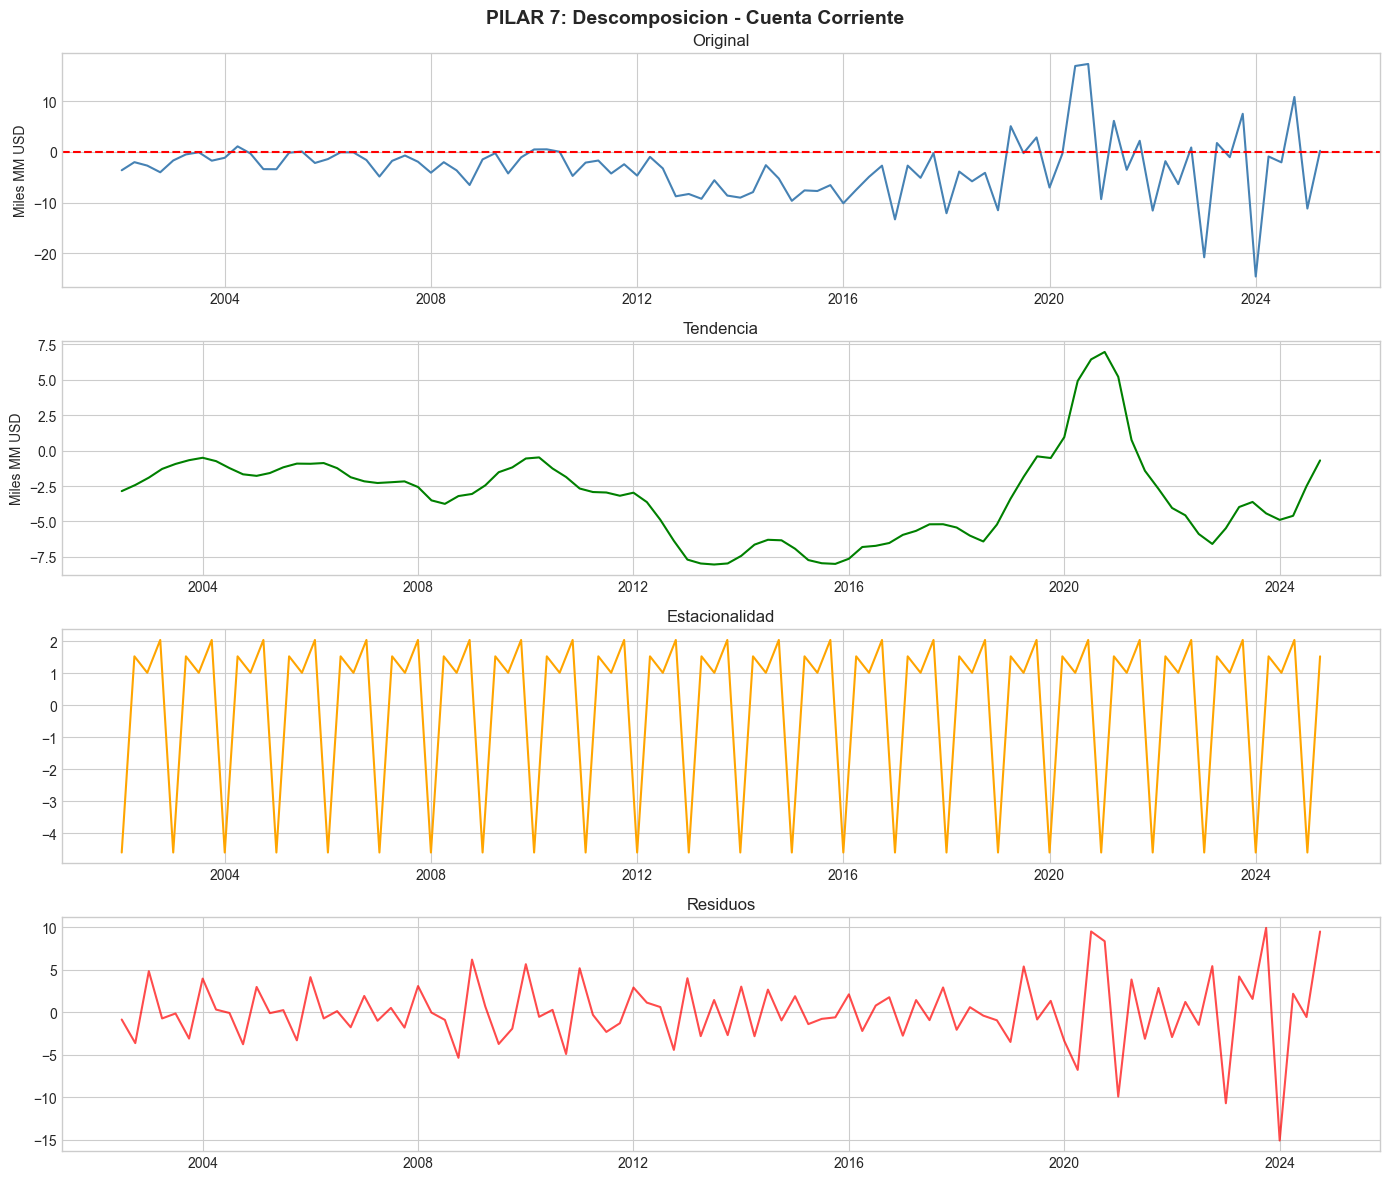

In [17]:
if len(ts_data.dropna()) >= 8:
    decomp = seasonal_decompose(ts_data.dropna(), model='additive', period=4)
    
    fig, axes = plt.subplots(4, 1, figsize=(14, 12))
    fig.suptitle('PILAR 7: Descomposicion - Cuenta Corriente', fontsize=14, fontweight='bold')
    
    axes[0].plot(ts_data/1000, color='steelblue')
    axes[0].axhline(0, color='red', linestyle='--')
    axes[0].set_title('Original')
    axes[0].set_ylabel('Miles MM USD')
    
    axes[1].plot(decomp.trend/1000, color='green')
    axes[1].set_title('Tendencia')
    axes[1].set_ylabel('Miles MM USD')
    
    axes[2].plot(decomp.seasonal/1000, color='orange')
    axes[2].set_title('Estacionalidad')
    
    axes[3].plot(decomp.resid/1000, color='red', alpha=0.7)
    axes[3].set_title('Residuos')
    
    plt.tight_layout()
    plt.show()

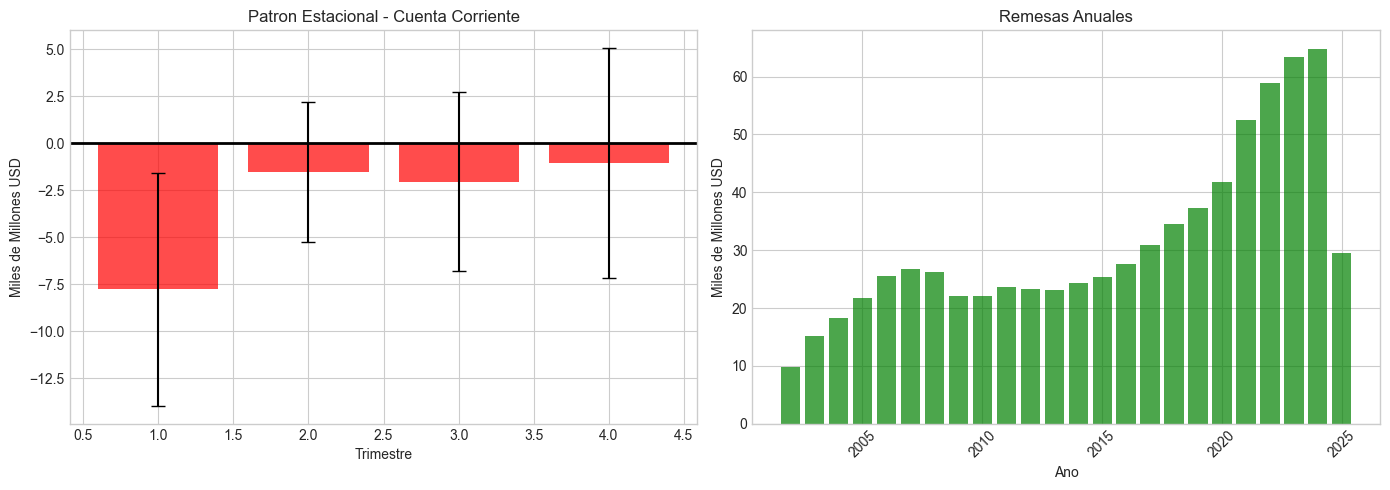

In [18]:
# Patron estacional
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

patron = df.groupby('TRIMESTRE')['CuentaCorriente'].agg(['mean', 'std'])
colors = ['green' if m > 0 else 'red' for m in patron['mean']]
axes[0].bar(patron.index, patron['mean']/1000, yerr=patron['std']/1000, capsize=5, color=colors, alpha=0.7)
axes[0].axhline(0, color='black', linewidth=2)
axes[0].set_xlabel('Trimestre')
axes[0].set_ylabel('Miles de Millones USD')
axes[0].set_title('Patron Estacional - Cuenta Corriente')

# Evolucion remesas
if 'Remesas' in df.columns:
    anual = df.groupby('year')['Remesas'].sum()
    axes[1].bar(anual.index, anual.values/1000, color='green', alpha=0.7)
    axes[1].set_xlabel('Ano')
    axes[1].set_ylabel('Miles de Millones USD')
    axes[1].set_title('Remesas Anuales')
    axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

---
## PILAR 8: ANOVA

In [19]:
print("PILAR 8: ANOVA")
print("="*80)

# ANOVA por trimestre
grupos = [df[df['TRIMESTRE'] == t]['CuentaCorriente'].dropna() for t in [1, 2, 3, 4]]
grupos = [g for g in grupos if len(g) >= 3]

if len(grupos) >= 2:
    f_stat, p_anova = stats.f_oneway(*grupos)
    print(f"ANOVA Trimestre: F={f_stat:.4f}, p={p_anova:.4f}")
    print(f"Conclusion: {'Diferencia significativa' if p_anova < 0.05 else 'Sin diferencia'}")
else:
    f_stat, p_anova = 0, 1.0

# ANOVA por decada
df['decada'] = (df['year'] // 10) * 10
grupos_dec = [df[df['decada'] == d]['CuentaCorriente'].dropna() for d in df['decada'].unique()]
grupos_dec = [g for g in grupos_dec if len(g) >= 3]

if len(grupos_dec) >= 2:
    f_stat2, p_anova2 = stats.f_oneway(*grupos_dec)
    print(f"\nANOVA Decada: F={f_stat2:.4f}, p={p_anova2:.6f}")
else:
    f_stat2, p_anova2 = 0, 1.0

PILAR 8: ANOVA
ANOVA Trimestre: F=8.3826, p=0.0001
Conclusion: Diferencia significativa

ANOVA Decada: F=3.3289, p=0.040245


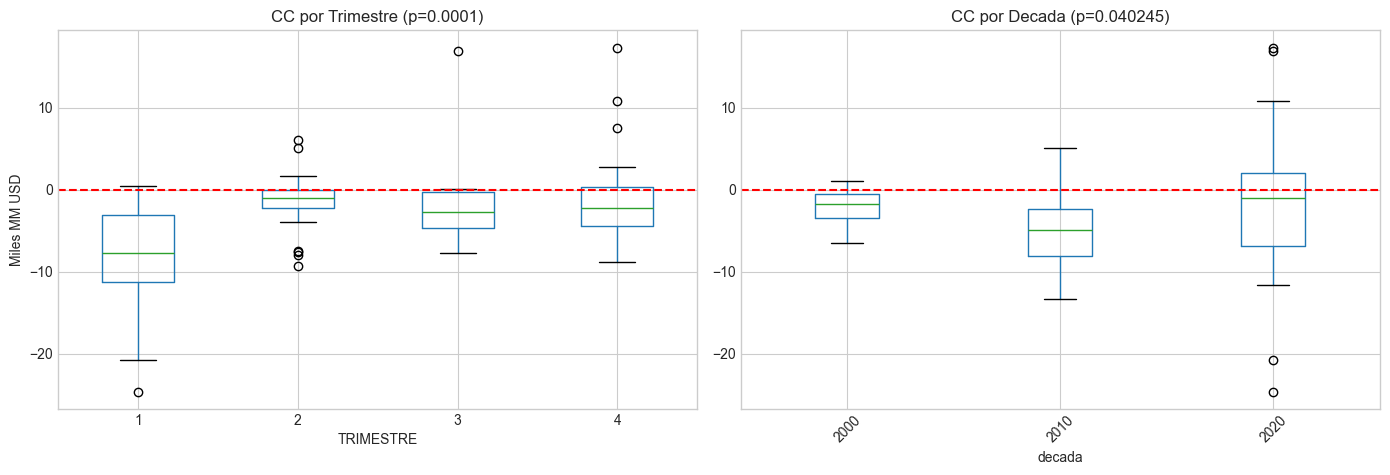

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('PILAR 8: ANOVA', fontsize=14, fontweight='bold')

df_plot = df.copy()
df_plot['CuentaCorriente'] = df_plot['CuentaCorriente'] / 1000

df_plot.boxplot(column='CuentaCorriente', by='TRIMESTRE', ax=axes[0])
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_title(f'CC por Trimestre (p={p_anova:.4f})')
axes[0].set_ylabel('Miles MM USD')
plt.suptitle('')

df_plot.boxplot(column='CuentaCorriente', by='decada', ax=axes[1])
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_title(f'CC por Decada (p={p_anova2:.6f})')
axes[1].tick_params(axis='x', rotation=45)
plt.suptitle('')

plt.tight_layout()
plt.show()

---
## RESUMEN EJECUTIVO

In [21]:
print("="*80)
print("RESUMEN: 8 PILARES - BALANZA DE PAGOS")
print("="*80)

print(f"\n1. DISTRIBUCIONES: Mayoria No Normal (sesgo por deficit persistente)")

print(f"\n2. CENTRO DE GRAVEDAD:")
print(f"   - Cuenta Corriente Media: {df['CuentaCorriente'].mean()/1000:.2f} miles MM USD")
print(f"   - Exportaciones Media: {df['Exportaciones'].mean()/1000:.2f} miles MM USD")
if 'Remesas' in df.columns:
    print(f"   - Remesas Media: {df['Remesas'].mean()/1000:.2f} miles MM USD")

print(f"\n3. FIABILIDAD:")
cv_cc = df['CuentaCorriente'].std() / abs(df['CuentaCorriente'].mean()) * 100
print(f"   - CV Cuenta Corriente: {cv_cc:.1f}% (Alta volatilidad)")

print(f"\n4. MARGEN DE ERROR: Ver tabla IC arriba")

print(f"\n5. CHI-CUADRADA:")
print(f"   - CC vs Trimestre: p={p_value:.4f}")

print(f"\n6. ML: {mejor_modelo} (R2={df_resultados.iloc[0]['R2']:.4f})")

print(f"\n7. SERIES DE TIEMPO: {'ESTACIONARIA' if adf_result[1] < 0.05 else 'NO ESTACIONARIA'}")

print(f"\n8. ANOVA:")
print(f"   - Por trimestre: p={p_anova:.4f}")
print(f"   - Por decada: p={p_anova2:.6f}")

print("\n" + "="*80)

RESUMEN: 8 PILARES - BALANZA DE PAGOS

1. DISTRIBUCIONES: Mayoria No Normal (sesgo por deficit persistente)

2. CENTRO DE GRAVEDAD:
   - Cuenta Corriente Media: -3.14 miles MM USD
   - Exportaciones Media: 92.07 miles MM USD
   - Remesas Media: 7.96 miles MM USD

3. FIABILIDAD:
   - CV Cuenta Corriente: 187.3% (Alta volatilidad)

4. MARGEN DE ERROR: Ver tabla IC arriba

5. CHI-CUADRADA:
   - CC vs Trimestre: p=0.1395

6. ML: Gradient Boosting (R2=0.4432)

7. SERIES DE TIEMPO: NO ESTACIONARIA

8. ANOVA:
   - Por trimestre: p=0.0001
   - Por decada: p=0.040245

